- **문제**   
*"각 패널에게 어떤 온라인 설문조사를 요청해야 응답할까?"*    
**KML Challenge 2023F**에서는 이 문제를 가장 잘 해결할 수 있는 예측 모델을 개발하는 것이 목적
- **평가척도**   
정확도(Accuracy)
- **데이터**   
   - train.csv(학습데이터), test.csv(평가테이터)
   - 각 데이터 포인트는 패널 정보, 설문정보, 응답여부(STATUS)로 구성

### Imports

In [1]:
# Data Wrangling
import pandas as pd
import numpy as np
import pandas_profiling as pp
import gzip
import gc

# Visualization, EDA
import missingno as msno
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# Korean font
#font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
#rc('font', family=font_name)

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import optuna

# Modeling
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import *
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import ClassifierMixin

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from keras.callbacks import ModelCheckpoint

# Utility
import re
import os
import time
import datetime
import random
import tensorflow as tf
import pickle
import joblib
import platform
import warnings; warnings.filterwarnings("ignore")
from itertools import combinations
from tqdm import tqdm, tqdm_notebook
from IPython.display import Image
from scipy.stats.mstats import gmean
from tensorflow import keras
from PIL import Image
from tqdm.auto import trange

from sklearn.datasets import make_classification

from sklearn.ensemble import BaggingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import KFold

import shap # v2.0부터 추가
from featurizer import KMeansFeaturizer # v2.0부터 추가

C:\Users\7johs\AppData\Local\Temp\ipykernel_11812\2739996170.py:4: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


### Data Loading

In [2]:
train = pd.read_csv('train.csv', encoding='cp949')
test = pd.read_csv('test.csv', encoding='cp949')

### 데이터 설명
- **패널(Panel) 데이터**
  - userID: 패널 ID
  - BIRTH: 생일(연도)
  - GENDER: 1(남자) 2(여자)
  - REGION: 거주지역
  - TYPE: 패널 구분
  - SQ1 ~ DQ7: 패널 가입 시 설문한 데이터로 각 필드에 대해서는 [상세설명](https://docs.google.com/spreadsheets/d/1pY6MYTSkyHrGLmMTU8tX_xlD8fPut6Ob/edit?usp=sharing&ouid=107121563618260277687&rtpof=true&sd=true) 참조
- **설문(Survey) 데이터**
  - surveyID: 설문 ID
  - TITLE: 설문 제목
  - IR: 난이도(응답가능성, 100이 최고)
  - LOI: 설문하는데 걸리는 시간 (분단위)
  - CATEGORIES: 설문 분류
  - CPI: 패널 응답 리워드 포인트(1P~)
- **응답(Response) 데이터**
  - STATUS: 응답여부 (Target)
  - (test 데이터의) ID: submission을 식별하기 위한 ID로 사용

### Feature Preprocessing & Engineering

In [3]:
# 거주 주택 유형
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5', '6']:
        return int(x)
    elif x in ['1,', '2,', '3,', '4,', '5,', '6,']:
        return int(x[0])
    else:
        return 99

train.SQ4 = train.SQ4.apply(handle_profile)
test.SQ4 = test.SQ4.apply(handle_profile)

In [4]:
# 최종 학력
def handle_profile(x):
    if x in ['1', '2', '3', '4']:
        return int(x)
    elif x in ['1.0', '2.0', '3.0', '4.0']:
        return int(x[0])
    else:
        return 99

train.SQ5 = train.SQ5.apply(handle_profile)
test.SQ5 = test.SQ5.apply(handle_profile)

In [5]:
# 결혼 여부
def handle_profile(x):
    if x in ['1', '2']:
        return int(x)
    elif x in ['1,', '2,']:
        return int(x[0])
    else:
        return 99

train.SQ6 = train.SQ6.apply(handle_profile)
test.SQ6 = test.SQ6.apply(handle_profile)

In [6]:
# 첫째 자녀의 성별과 연령
value1 = pd.Series(range(1,17)).apply(lambda x: str(x)).tolist()
value2 = pd.Series(np.arange(1.0,17.0)).apply(lambda x: str(x)).tolist()
def handle_profile(x):
    if x in value1:
        return int(x)
    elif x in value2:
        return int(x[0])
    else:
        return 99

train.SQ7 = train.SQ7.apply(handle_profile)
test.SQ7 = test.SQ7.apply(handle_profile)

In [7]:
# 같이 살고 있는 가족 구성원 수
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5']:
        return int(x)
    else:
        return 99

train.SQ8 = train.SQ8.apply(handle_profile)
test.SQ8 = test.SQ8.apply(handle_profile)

In [8]:
# 최근 1년 이내에 새로 구입하신 가전제품
values = pd.Series(range(1,23)).apply(lambda x: str(x)).tolist()
def handle_profile(x):    
    if x in values:
        return int(x)
    else:
        return 99

train.A1 = train.A1.apply(handle_profile)
test.A1 = test.A1.apply(handle_profile)

In [9]:
# 현재 사용 중인 휴대폰의 인터넷 통신망
def handle_profile(x):    
    if x in ['1']:
        return 2
    elif x in ['2', '3']:
        return 3
    elif x in ['4', '5', '6', '7']:
        return 4
    elif x in ['8']:
        return 5
    else:
        return 99

train.B1 = train.B1.apply(handle_profile)
test.B1 = test.B1.apply(handle_profile)

In [10]:
# 현재 사용 중인 휴대폰의 이동통신사
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5', '6']:
        return int(x)
    else:
        return 99

train.B2 = train.B2.apply(handle_profile)
test.B2 = test.B2.apply(handle_profile)

In [11]:
# 현재 사용 중인 휴대폰의 제조사
def handle_profile(x):    
    if x in ['1', '2', '3']:
        return int(x)
    elif x in ['1,', '2,', '3,']:
        return int(x[0])
    elif x in ['99', '99,']:
        return 99
    else:
        return 4  # 기타 제조사

train.B3 = train.B3.apply(handle_profile)
test.B3 = test.B3.apply(handle_profile)

In [12]:
# 현재 보유하고 사용하고 있는 스마트 기기
def handle_profile(x):    
    if x != x :
        return 0
    elif x in ['1', '2', '3', '4', '5', '6', '7' , '99', '97']:
        return int(x)
    else:
        return 98

train.B4 = train.B4.apply(handle_profile)
test.B4 = test.B4.apply(handle_profile)

In [13]:
# 현재 이용 중인 케이블 TV
def handle_profile(x):    
    if x != x :
        return 0
    elif x in ['1', '2', '3', '4' ,'5', '6', '7', '8', '9', '10']:
        return int(x)
    elif x in ['1,', '2,', '3,', '4,' ,'5,', '6,', '7,', '8,', '9,', '10,']:
        return int(x[0])
    elif x in ['99', '99,']:
        return 99
    else:
        return 4  # 기타 제조사

train.B5 = train.B5.apply(handle_profile)
test.B5 = test.B5.apply(handle_profile)

In [14]:
# TITLE 피쳐에서 '-' 값을 모두 제거하여 TITLE-test 피쳐 생성
train['TITLEtest'] = train['TITLE'].str.replace('-', '')
test['TITLEtest'] = test['TITLE'].str.replace('-', '')

def assign_group(title):
    if 'DR' in title and title.endswith('L'):
        return 1
    elif 'DR' in title and title.endswith('S'):
        return 2                                    
    elif 'G' in title:
        return 3
    elif 'DN' in title:
        return 4
    elif 'IM' in title:
        return 5
    elif 'BL' in title:
        return 6
    elif '소비자' in title or '소비사' in title:
        return 7
    elif '주류' in title: 
        return 8
    elif '일반국민' in title: 
        return 9
    elif '국민' in title: 
        return 10
    elif '광고' in title: 
        return 11
    elif '서비스' in title: 
        return 12
    elif '외국어' in title: 
        return 13
    elif '해외' not in title and '일반인' in title:
        return 14
    else:
        return 99

#조건에 따라 특정 문자열 패턴이 있는지 확인하고, 해당 페턴에 맞는 그룹 번호 할당
train['TITLE2'] = train['TITLEtest'].apply(assign_group)
test['TITLE2'] = test['TITLEtest'].apply(assign_group)


def assign_group(title):
    match_dr = re.search(r'DR(\d)', title)
    
    if match_dr:
        dr_number = int(match_dr.group(1))
        last_char = title[-1]
        
        if last_char == 'L':
            return dr_number
        elif last_char == 'S':
            return dr_number + 10
    elif 'G' in title:
        return 21
    elif 'DN' in title:
        return 22
    elif 'IM' in title:
        return 23
    elif 'BL' in title:
        return 24
    elif '소비자' in title or '소비사' in title:
        return 25
    elif '주류' in title: 
        return 26
    elif '일반국민' in title: 
        return 27
    elif '국민' in title: 
        return 28
    elif '광고' in title: 
        return 29
    elif '서비스' in title: 
        return 30
    elif '외국어' in title: 
        return 31
    elif '해외' not in title and '일반인' in title:
        return 32
    else:
        return 99

# 'DR'로 시작하고 숫자가 뒤따르는 패턴을 찾아 그룹 번호 할당
train['TITLE1'] = train['TITLEtest'].apply(assign_group)
test['TITLE1'] = test['TITLEtest'].apply(assign_group)

# 'TITLEtest' 열을 'train'과 'test' 데이터에서 제거
train.drop('TITLEtest', axis=1, inplace=True)
test.drop('TITLEtest', axis=1, inplace=True)

# 'STATUS'가 1인 경우에 해당하는 'TITLE1' 값의 빈도
res_freq = train.query('STATUS == 1').groupby('TITLE1')['TITLE1'].agg([('FREQ', np.size)]).reset_index()
# 전체 'TITLE1' 값의 빈도
send_freq = train.groupby('TITLE1')['TITLE1'].agg([('SEND', np.size)]).reset_index()
train = train.merge(res_freq, how='left').merge(send_freq, how='left')

# 'FREQ'를 'SEND'로 나누어 계산한 응답률
train['RESRATE_T'] = train['FREQ'] / train['SEND']
del train['FREQ'], train['SEND']

# 'RESRATE_T'를 'test' 데이터에 추가
test = pd.merge(test, train.drop_duplicates(subset=['TITLE1'])[['TITLE1', 'RESRATE_T']], how='left')
test['RESRATE_T'] = test['RESRATE_T'].fillna(0)

# 'TITLE1' 열 제거
train.drop('TITLE1', axis=1, inplace=True)
test.drop('TITLE1', axis=1, inplace=True)

In [15]:
word_counts = {}

# 응답한 서베이 제목에서 한글 단어만 분리하고 빈도 계산
def count_word(x):
    if x['STATUS'] == 1:
        for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
            word_counts[w] = word_counts.get(w, 0) + 1

# 빈도의 합으로 제목을 Encoding
def score_word(x):
    score = 0
    for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
        score += word_counts.get(w, 0)
    return score    
            
train.apply(count_word, axis=1)
train.TITLE = train.apply(score_word, axis=1)
test.TITLE = test.apply(score_word, axis=1)

In [16]:
train["CATEGORIES_CNT"]=0
test["CATEGORIES_CNT"]=0

train["CATEGORIES"]=train["CATEGORIES"].fillna("unknown")
test["CATEGORIES"]=test["CATEGORIES"].fillna("unknown")
word_counts = {}

# 응답한 서베이 'CATEGORIES'에서 영어 단어만 분리하여 빈도 계산
def count_word(x):
    if x['STATUS'] == 1:
        for w in re.sub(r'[^a-zA-Z]', '', x['CATEGORIES']).split():
            word_counts[w] = word_counts.get(w, 0) + 1

# 빈도의 합으로 'CATEGORIES_CNT' 열에 저장
def score_word(x):
    score = 0
    for w in re.sub(r'[^a-zA-Z]', '', x['CATEGORIES']).split():
        score += word_counts.get(w, 0)
    return score    
            
train.apply(count_word, axis=1)
train.CATEGORIES_CNT = train.apply(score_word, axis=1)
test.CATEGORIES_CNT = test.apply(score_word, axis=1)

In [17]:
from sklearn.preprocessing import LabelEncoder

# 'LabelEncoder' 객체 초기화
encoder = LabelEncoder()

# 'train' 데이터셋의 'CATEGORIES'열을 사용하여 'LabelEncoder'를 피팅하고, 이를 라벨숫자로 변환
encoder.fit(train["CATEGORIES"])
train_encoded_cat = encoder.transform(train["CATEGORIES"])

# 'test' 데이터셋의 'CATEGORIES' 열에서 새로운 레이블을 확인하고, 이를 'LabelEncoder'에 추가
for label in np.unique(test["CATEGORIES"]):
    if label not in encoder.classes_: 
        encoder.classes_ = np.append(encoder.classes_, label)

# 'test' 데이터셋의 'CATEGORIES' 열을 라벨숫자로 변환
test_encoded_cat = encoder.transform(test["CATEGORIES"])

# 변환된 결과를 원래 데이터프레임의 'CATEGORIES'열에 저장
train["CATEGORIES"] = pd.DataFrame(train_encoded_cat)
test["CATEGORIES"] = pd.DataFrame(test_encoded_cat)

del train_encoded_cat, test_encoded_cat

In [18]:
# 'STATUS'가 1인 경우를 기준으로 'userID'별 응답 빈도(FREQ)를 계산
res_freq = train.query('STATUS == 1').groupby('userID')['userID'].agg([('FREQ',np.size)]).reset_index()
# 전체 데이터에서 'userID'별 전체 서베이 횟수(SEND)를 계산
send_freq = train.groupby('userID')['userID'].agg([('SEND',np.size)]).reset_index()

# 'FREQ'와 'SEND'를 이용해 응답률(RESRATE)를 계산하고, 이를 'train' 데이터셋에 추가
train = train.merge(res_freq, how='left').merge(send_freq, how='left')
train['RESRATE'] = train['FREQ'] / train['SEND']
del train['FREQ'], train['SEND']

# 'test'데이터셋에 'train' 데이터셋의 'RESRATE'를 'userID' 기준으로 추가하고, 결측값은 0으로 채움
test = pd.merge(test, train.drop_duplicates(subset=['userID'])[['userID', 'RESRATE']], how='left')
test['RESRATE'] = test['RESRATE'].fillna(0) 

In [19]:
# 'STATUS'가 1인 경우를 기준으로 'surveyID'별 응답 빈도(FREQ)를 계산
res_freq = train.query('STATUS == 1').groupby('surveyID')['surveyID'].agg([('FREQ', np.size)]).reset_index()
# 전체 데이터에서 'survey'별 전체 서베이 횟수(SEND)를 계산
send_freq = train.groupby('surveyID')['surveyID'].agg([('SEND', np.size)]).reset_index()

# 'FREQ'와 'SEND'를 이용해 응답률(RESRATE_S)를 계산하고, 이를 'train' 데이터셋에 추가
train = train.merge(res_freq, how='left').merge(send_freq, how='left')
train['RESRATE_S'] = train['FREQ'] / train['SEND']
del train['FREQ'], train['SEND']

# 'test'데이터셋에 'train' 데이터셋의 'RESRATE_S'를 'surveyID' 기준으로 추가하고, 결측값은 0으로 채움
test = pd.merge(test, train.drop_duplicates(subset=['surveyID'])[['surveyID', 'RESRATE_S']], how='left')
test['RESRATE_S'] = test['RESRATE_S'].fillna(0)

In [20]:
#IR별 응답률
train_IR = ((train.groupby('IR')['STATUS'].sum())/(train.IR.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_IR'})
train = train.merge(train_IR,how='left')
test = test.merge(train_IR,how='left')

In [21]:
#LOI별 응답률
train_LOI = ((train.groupby('LOI')['STATUS'].sum())/(train.LOI.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_LOI'})
train = train.merge(train_LOI,how='left')
test = test.merge(train_LOI,how='left')

In [22]:
#CPI 별 응답률
train_CPI = ((train.groupby('CPI')['STATUS'].sum())/(train.CPI.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_CPI'})
train = train.merge(train_CPI,how='left')
test = test.merge(train_CPI,how='left')

In [23]:
#TYPE 별 응답률
train_TYPE = ((train.groupby('TYPE')['STATUS'].sum())/(train.TYPE.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_TYPE'})
train = train.merge(train_TYPE,how='left')
test = test.merge(train_TYPE,how='left')

In [24]:
#BIRTH 별 응답률
train_BIRTH = ((train.groupby('BIRTH')['STATUS'].sum())/(train.BIRTH.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_BIRTH'})
train = train.merge(train_BIRTH,how='left')
test = test.merge(train_BIRTH,how='left')


In [25]:
#REGION 별 응답률
train_REGION = ((train.groupby('REGION')['STATUS'].sum())/(train.REGION.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_REGION'})
train = train.merge(train_REGION,how='left')
test = test.merge(train_REGION,how='left')

In [26]:
#성별 응답률
train_GENDER = ((train.groupby('GENDER')['STATUS'].sum())/(train.GENDER.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_GENDER'})
train = train.merge(train_GENDER,how='left')
test = test.merge(train_GENDER,how='left')

In [27]:
#유저 아이디별 응답 횟수
res_cnt = train[train.STATUS== 1].groupby("userID").surveyID.count()
train["res_cnt"] = train["userID"].map(dict(res_cnt))
test["res_cnt"] = test["userID"].map(dict(res_cnt))

test["res_cnt"] = test["res_cnt"].fillna(0)

In [28]:
#survey 아이디별 응답 횟수
res_cnt = train[train.STATUS== 1].groupby("surveyID").userID.count()
train["res_cnt_survey"] = train["surveyID"].map(dict(res_cnt))
test["res_cnt_survey"] = test["surveyID"].map(dict(res_cnt))

test["res_cnt_survey"] = test["res_cnt_survey"].fillna(0)

In [29]:
# 패널 ID 별 획득 누적 포인트
Points_earned = pd.DataFrame(train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned',np.sum)])).reset_index()

# 패널 ID 별 획득 평균 포인트
Points_earned_mean = pd.DataFrame(train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned_mean',np.mean)])).reset_index()

train = train.merge(Points_earned, how='left')
test = test.merge(Points_earned, how='left')

train = train.merge(Points_earned_mean, how='left')
test = test.merge(Points_earned_mean, how='left')

test['Points_earned'].fillna(0, inplace = True) 
test['Points_earned_mean'].fillna(0, inplace = True)

In [30]:
train["AGE"] = 2022- train["BIRTH"]
test["AGE"] = 2022- test["BIRTH"]

In [31]:
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90,100]
labels = ['10', '20', '30', '40', '50', '60', '70', '80','90']

#연령대
train['Age_Group'] = pd.cut(train['AGE'], bins=bins, labels=labels, right=False)
test['Age_Group'] = pd.cut(train['AGE'], bins=bins, labels=labels, right=False)

train['Age_Group'] = train['Age_Group'].astype('int')
test['Age_Group'] = test['Age_Group'].astype('int') 

In [32]:
# GENDER별 CPI 통계 정보 생성
GENDER_CPI = pd.DataFrame(train.query('STATUS==1').groupby('GENDER')['CPI'].agg([
    ('GENDER_TOT_CPI', lambda x: np.sum(x)),
    ('GENDER_AVG_CPI', lambda x: np.mean(x)),
    ('GENDER_MIN_CPI', lambda x: np.min(x)),
    ('GENDER_MAX_CPI', lambda x: np.max(x))])).reset_index()

# GENDER별 LOI 통계 정보 생성
GENDER_LOI = pd.DataFrame(train.query('STATUS==1').groupby('GENDER')['LOI'].agg([
    ('GENDER_TOT_LOI', lambda x: np.sum(x)),
    ('GENDER_AVG_LOI', lambda x: np.mean(x)),
    ('GENDER_MIN_LOI', lambda x: np.min(x)),
    ('GENDER_MAX_LOI', lambda x: np.max(x))
])).reset_index()

# GENDER별 IR 통계 정보 생성
GENDER_IR = pd.DataFrame(train.query('STATUS==1').groupby('GENDER')['IR'].agg([
    ('GENDER_TOT_IR', lambda x: np.sum(x)),
    ('GENDER_AVG_IR', lambda x: np.mean(x)),
    ('GENDER_MIN_IR', lambda x: np.min(x)),
    ('GENDER_MAX_IR', lambda x: np.max(x))
])).reset_index()

train = train.merge(GENDER_CPI, how='left').merge(GENDER_LOI, how='left').merge(GENDER_IR, how='left')
test = test.merge(GENDER_CPI, how='left').merge(GENDER_LOI, how='left').merge(GENDER_IR, how='left')

In [33]:
# REGION별 CPI 통계 정보 생성
REGION_CPI = pd.DataFrame(train.query('STATUS==1').groupby('REGION')['CPI'].agg([
    ('REGION_TOT_CPI', lambda x: np.sum(x)),
    ('REGION_AVG_CPI', lambda x: np.mean(x)),
    ('REGION_MIN_CPI', lambda x: np.min(x)),
    ('REGION_MAX_CPI', lambda x: np.max(x))])).reset_index()

# REGION별 LOI 통계 정보 생성
REGION_LOI = pd.DataFrame(train.query('STATUS==1').groupby('REGION')['LOI'].agg([
    ('REGION_TOT_LOI', lambda x: np.sum(x)),
    ('REGION_AVG_LOI', lambda x: np.mean(x)),
    ('REGION_MIN_LOI', lambda x: np.min(x)),
    ('REGION_MAX_LOI', lambda x: np.max(x))
])).reset_index()

# REGION별 IR 통계 정보 생성
REGION_IR = pd.DataFrame(train.query('STATUS==1').groupby('REGION')['IR'].agg([
    ('REGION_TOT_IR', lambda x: np.sum(x)),
    ('REGION_AVG_IR', lambda x: np.mean(x)),
    ('REGION_MIN_IR', lambda x: np.min(x)),
    ('REGION_MAX_IR', lambda x: np.max(x))
])).reset_index()

train = train.merge(REGION_CPI, how='left').merge(REGION_LOI, how='left').merge(REGION_IR, how='left')
test = test.merge(REGION_CPI, how='left').merge(REGION_LOI, how='left').merge(REGION_IR, how='left')

In [34]:
# TYPE별 CPI 통계 정보 생성
TYPE_CPI = pd.DataFrame(train.query('STATUS==1').groupby('TYPE')['CPI'].agg([
    ('TYPE_TOT_CPI', lambda x: np.sum(x)),
    ('TYPE_AVG_CPI', lambda x: np.mean(x)),
    ('TYPE_MIN_CPI', lambda x: np.min(x)),
    ('TYPE_MAX_CPI', lambda x: np.max(x))])).reset_index()

# TYPE별 LOI 통계 정보 생성
TYPE_LOI = pd.DataFrame(train.query('STATUS==1').groupby('TYPE')['LOI'].agg([
    ('TYPE_TOT_LOI', lambda x: np.sum(x)),
    ('TYPE_AVG_LOI', lambda x: np.mean(x)),
    ('TYPE_MIN_LOI', lambda x: np.min(x)),
    ('TYPE_MAX_LOI', lambda x: np.max(x))
])).reset_index()

# TYPE별 IR 통계 정보 생성
TYPE_IR = pd.DataFrame(train.query('STATUS==1').groupby('TYPE')['IR'].agg([
    ('TYPE_TOT_IR', lambda x: np.sum(x)),
    ('TYPE_AVG_IR', lambda x: np.mean(x)),
    ('TYPE_MIN_IR', lambda x: np.min(x)),
    ('TYPE_MAX_IR', lambda x: np.max(x))
])).reset_index()

train = train.merge(TYPE_CPI, how='left').merge(TYPE_LOI, how='left').merge(TYPE_IR, how='left')
test = test.merge(TYPE_CPI, how='left').merge(TYPE_LOI, how='left').merge(TYPE_IR, how='left')

In [35]:
# AGE_Group별 CPI 통계 정보 생성
Age_Group_CPI = pd.DataFrame(train.query('STATUS==1').groupby('Age_Group')['CPI'].agg([
    ('Age_Group_TOT_CPI', lambda x: np.sum(x)),
    ('Age_Group_AVG_CPI', lambda x: np.mean(x)),
    ('Age_Group_MIN_CPI', lambda x: np.min(x)),
    ('Age_Group_MAX_CPI', lambda x: np.max(x))])).reset_index()

# AGE_Group별 LOI 통계 정보 생성
Age_Group_LOI = pd.DataFrame(train.query('STATUS==1').groupby('Age_Group')['LOI'].agg([
    ('Age_Group_TOT_LOI', lambda x: np.sum(x)),
    ('Age_Group_AVG_LOI', lambda x: np.mean(x)),
    ('Age_Group_MIN_LOI', lambda x: np.min(x)),
    ('Age_Group_MAX_LOI', lambda x: np.max(x))
])).reset_index()

# AGE_Group별 IR 통계 정보 생성
Age_Group_IR = pd.DataFrame(train.query('STATUS==1').groupby('Age_Group')['IR'].agg([
    ('Age_Group_TOT_IR', lambda x: np.sum(x)),
    ('Age_Group_AVG_IR', lambda x: np.mean(x)),
    ('Age_Group_MIN_IR', lambda x: np.min(x)),
    ('Age_Group_MAX_IR', lambda x: np.max(x))
])).reset_index()

train = train.merge(Age_Group_CPI, how='left').merge(Age_Group_LOI, how='left').merge(Age_Group_IR, how='left')
test = test.merge(Age_Group_CPI, how='left').merge(Age_Group_LOI, how='left').merge(Age_Group_IR, how='left')

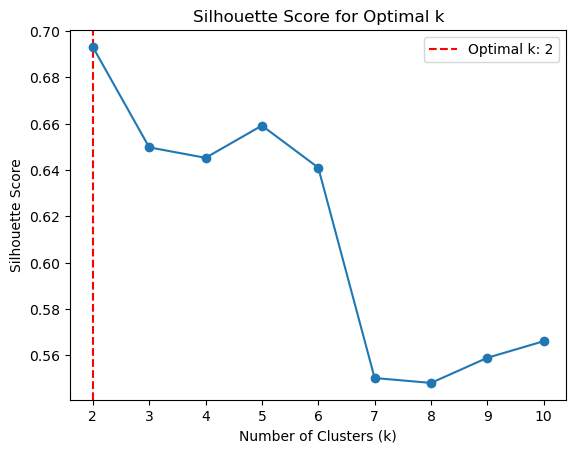

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 'surveyID'와 'STATUS'열을 선택하여 데이터셋 생성
data = train[['surveyID', 'STATUS']]

# 'surveyID'별로 평균 'STATUS' 계산
data = data.groupby(['surveyID']).mean()

# 'STATUS' 값을 numpy 배열로 변환 및 재구성
arr = data['STATUS'].to_numpy().reshape(-1, 1)

# Silhouette 계수를 계산하여 최적의 군집 개수를 찾기 위한 준비
silhouette_scores = []
k_range = range(2, 11) 

# 각 k값에 대해 KMeans 군집화 및 Silhouette 계수 계산
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10)
    cluster_labels = kmeans.fit_predict(arr)
    silhouette_scores.append(silhouette_score(arr, cluster_labels))

# 최적의 군집 개수를 가진 인덱스를 찾음
optimal_k_index = silhouette_scores.index(max(silhouette_scores))
optimal_k = k_range[optimal_k_index]

# 최적의 k 지점에 빨간색 점선을 그림
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k: {optimal_k}')

# Silhouette 계수를 그래프로 표시
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.xticks(k_range)
plt.legend()
plt.show()

In [37]:
# 최적의 군집 개수로 KMeans 군집화 진행
optimal_k =  2
kmeans = KMeans(n_clusters=optimal_k, n_init=10)
kmeans.fit(arr)

# 클러스터 중심을 기준으로 군집의 순서를 정렬하기 위해 인덱스를 추출
sort_order = np.argsort(kmeans.cluster_centers_.flatten())

# 군집화 결과를 클러스터 중심 값 순서대로 재할당
labels = np.zeros_like(kmeans.labels_)
for i, cluster in enumerate(sort_order):
    labels[kmeans.labels_ == cluster] = i

# 군집화 결과를 데이터에 추가
data['cluster_1'] = labels
data = data.reset_index()
data = data[['surveyID', 'cluster_1']]

# `train` 데이터셋에 군집화 결과를 병합
train= pd.merge(train, data, how='left', left_on='surveyID', right_on='surveyID')
# `test` 데이터셋에 군집화 결과를 병합
test= pd.merge(test, data, how='left', left_on='surveyID', right_on='surveyID')

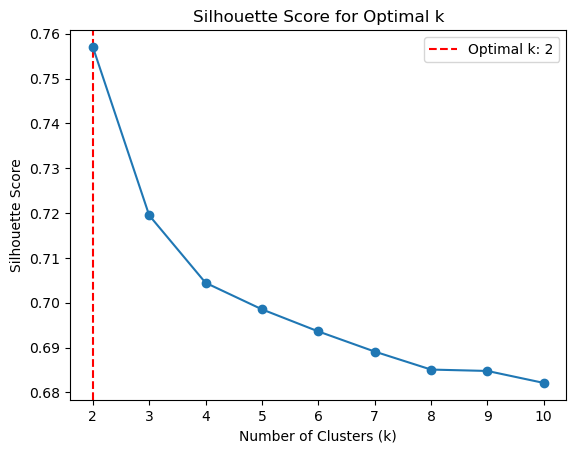

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 'userID'와 'STATUS'열을 선택하여 데이터셋 생성
data = train[['userID', 'STATUS']]

# 'userID'별로 평균 'STATUS' 계산
data = data.groupby(['userID']).mean()

arr = data['STATUS'].to_numpy().reshape(-1, 1)

silhouette_scores = []
k_range = range(2, 11) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10)
    cluster_labels = kmeans.fit_predict(arr)
    silhouette_scores.append(silhouette_score(arr, cluster_labels))

optimal_k_index = silhouette_scores.index(max(silhouette_scores))
optimal_k = k_range[optimal_k_index]

plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k: {optimal_k}')

plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.xticks(k_range)
plt.legend()
plt.show()

In [39]:
optimal_k =  2
kmeans = KMeans(n_clusters=optimal_k, n_init=10)
kmeans.fit(arr)

sort_order = np.argsort(kmeans.cluster_centers_.flatten())

labels = np.zeros_like(kmeans.labels_)
for i, cluster in enumerate(sort_order):
    labels[kmeans.labels_ == cluster] = i

data['cluster_2'] = labels
data = data.reset_index()
data = data[['userID', 'cluster_2']]

train= pd.merge(train, data, how='left', left_on='userID', right_on='userID')
test= pd.merge(test, data, how='left', left_on='userID', right_on='userID')

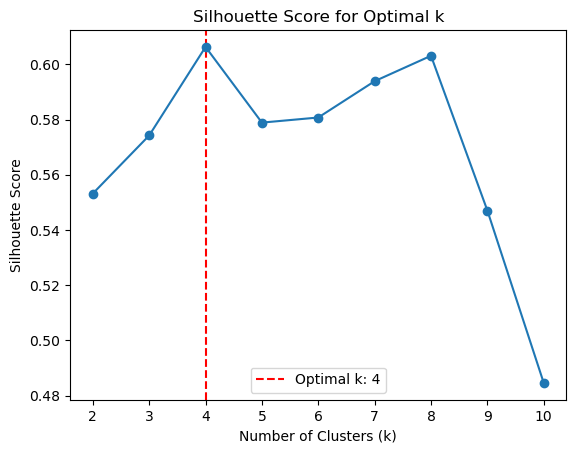

In [40]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 'REGION'과 'STATUS'열을 선택하여 데이터셋 생성
data = train[['REGION', 'STATUS']]

# 'REGION'별로 평균 'STATUS' 계산
data = data.groupby(['REGION']).mean()

arr = data['STATUS'].to_numpy().reshape(-1, 1)

silhouette_scores = []
k_range = range(2, 11) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10)
    cluster_labels = kmeans.fit_predict(arr)
    silhouette_scores.append(silhouette_score(arr, cluster_labels))

optimal_k_index = silhouette_scores.index(max(silhouette_scores))
optimal_k = k_range[optimal_k_index]

plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k: {optimal_k}')

plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.xticks(k_range)
plt.legend()
plt.show()

In [41]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, n_init=10)
kmeans.fit(arr)

sort_order = np.argsort(kmeans.cluster_centers_.flatten())

labels = np.zeros_like(kmeans.labels_)
for i, cluster in enumerate(sort_order):
    labels[kmeans.labels_ == cluster] = i

data['cluster_3'] = labels
data = data.reset_index()
data = data[['REGION', 'cluster_3']]

train= pd.merge(train, data, how='left', left_on='REGION', right_on='REGION')
test= pd.merge(test, data, how='left', left_on='REGION', right_on='REGION')

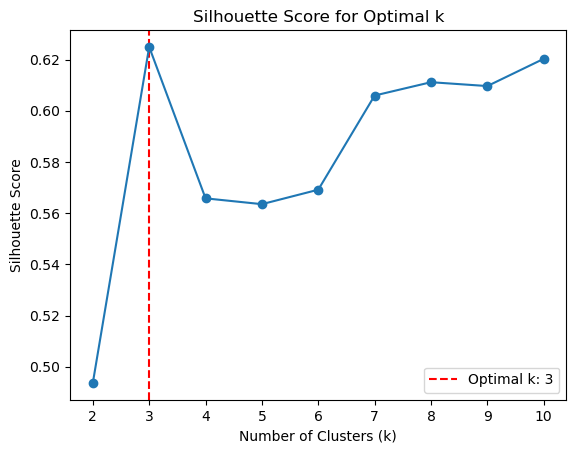

In [42]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 'IR'과 'STATUS'열을 선택하여 데이터셋 생성
data = train[['IR', 'STATUS']]

# 'IR'별로 평균 'STATUS' 계산
data = data.groupby(['IR']).mean()

arr = data['STATUS'].to_numpy().reshape(-1, 1)

silhouette_scores = []
k_range = range(2, 11) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10)
    cluster_labels = kmeans.fit_predict(arr)
    silhouette_scores.append(silhouette_score(arr, cluster_labels))

optimal_k_index = silhouette_scores.index(max(silhouette_scores))
optimal_k = k_range[optimal_k_index]

plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k: {optimal_k}')

plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.xticks(k_range)
plt.legend()
plt.show()

In [43]:
optimal_k =  3
kmeans = KMeans(n_clusters=optimal_k, n_init=10)
kmeans.fit(arr)

sort_order = np.argsort(kmeans.cluster_centers_.flatten())

labels = np.zeros_like(kmeans.labels_)
for i, cluster in enumerate(sort_order):
    labels[kmeans.labels_ == cluster] = i

data['cluster_4'] = labels
data = data.reset_index()
data = data[['IR', 'cluster_4']]

train= pd.merge(train, data, how='left', left_on='IR', right_on='IR')
test= pd.merge(test, data, how='left', left_on='IR', right_on='IR')

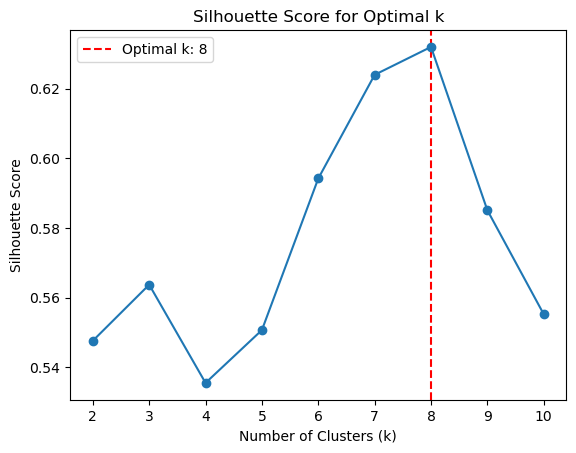

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 'LOI'와 'STATUS'열을 선택하여 데이터셋 생성
data = train[['LOI', 'STATUS']]

# 'LOI'별로 평균 'STATUS' 계산
data = data.groupby(['LOI']).mean()

arr = data['STATUS'].to_numpy().reshape(-1, 1)

silhouette_scores = []
k_range = range(2, 11) 
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10)
    cluster_labels = kmeans.fit_predict(arr)
    silhouette_scores.append(silhouette_score(arr, cluster_labels))

optimal_k_index = silhouette_scores.index(max(silhouette_scores))
optimal_k = k_range[optimal_k_index]

plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k: {optimal_k}')

plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.xticks(k_range)
plt.legend()
plt.show()

In [45]:
optimal_k =  8
kmeans = KMeans(n_clusters=optimal_k, n_init=10)
kmeans.fit(arr)

sort_order = np.argsort(kmeans.cluster_centers_.flatten())

labels = np.zeros_like(kmeans.labels_)
for i, cluster in enumerate(sort_order):
    labels[kmeans.labels_ == cluster] = i

data['cluster_5'] = labels
data = data.reset_index()
data = data[['LOI', 'cluster_5']]

train= pd.merge(train, data, how='left', left_on='LOI', right_on='LOI')
test= pd.merge(test, data, how='left', left_on='LOI', right_on='LOI')

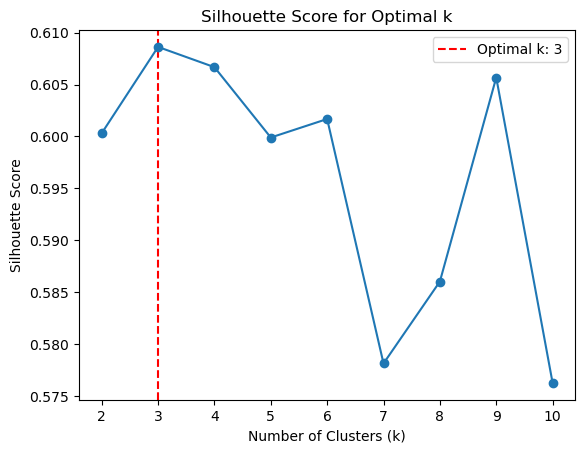

In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 'CPI'와 'STATUS'열을 선택하여 데이터셋 생성
data = train[['CPI', 'STATUS']]

# 'CPI'별로 평균 'STATUS' 계산
data = data.groupby(['CPI']).mean()

arr = data['STATUS'].to_numpy().reshape(-1, 1)

silhouette_scores = []
k_range = range(2, 11) 
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10)
    cluster_labels = kmeans.fit_predict(arr)
    silhouette_scores.append(silhouette_score(arr, cluster_labels))

optimal_k_index = silhouette_scores.index(max(silhouette_scores))
optimal_k = k_range[optimal_k_index]

plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k: {optimal_k}')

plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.xticks(k_range)
plt.legend()
plt.show()

In [47]:
optimal_k =  3
kmeans = KMeans(n_clusters=optimal_k, n_init=10)
kmeans.fit(arr)

sort_order = np.argsort(kmeans.cluster_centers_.flatten())

labels = np.zeros_like(kmeans.labels_)
for i, cluster in enumerate(sort_order):
    labels[kmeans.labels_ == cluster] = i
    
data['cluster_6'] = labels
data = data.reset_index()
data = data[['CPI', 'cluster_6']]

train= pd.merge(train, data, how='left', left_on='CPI', right_on='CPI')
test= pd.merge(test, data, how='left', left_on='CPI', right_on='CPI')

In [48]:
# 결측값 비율이 30% 이하인 column만 사용
features = []
for f in train.columns:
    if train[f].isnull().sum()/train.shape[0] <= 0.3:
        print(f, '\t', train[f].nunique(), '\t', train[f].isnull().sum()/train.shape[0])
        features.append(f)

userID 	 15155 	 0.0
surveyID 	 1293 	 0.0
BIRTH 	 76 	 0.0
GENDER 	 2 	 0.0
REGION 	 17 	 0.0
TYPE 	 3 	 0.0
SQ1 	 2 	 0.0009770785964481042
SQ2 	 82 	 0.0014293615190806859
SQ3 	 47 	 0.09023044306520002
SQ4 	 7 	 0.0
SQ5 	 5 	 0.0
SQ6 	 3 	 0.0
SQ7 	 17 	 0.0
SQ8 	 6 	 0.0
A1 	 23 	 0.0
B1 	 5 	 0.0
B2 	 7 	 0.0
B3 	 5 	 0.0
B4 	 11 	 0.0
B5 	 12 	 0.0
TITLE 	 28 	 0.0
IR 	 42 	 0.0
LOI 	 26 	 0.0
CATEGORIES 	 54 	 0.0
CPI 	 43 	 0.0
STATUS 	 2 	 0.0
TITLE2 	 15 	 0.0
RESRATE_T 	 33 	 0.0
CATEGORIES_CNT 	 53 	 0.0
RESRATE 	 2441 	 0.2463073803232348
RESRATE_S 	 1038 	 0.000838198242487556
STATUS_ratio_IR 	 42 	 0.0
STATUS_ratio_LOI 	 26 	 0.0
STATUS_ratio_CPI 	 43 	 0.0
STATUS_ratio_TYPE 	 3 	 0.0
STATUS_ratio_BIRTH 	 73 	 0.0
STATUS_ratio_REGION 	 17 	 0.0
STATUS_ratio_GENDER 	 2 	 0.0
res_cnt 	 108 	 0.2463073803232348
res_cnt_survey 	 460 	 0.000838198242487556
Points_earned 	 5809 	 0.2463073803232348
Points_earned_mean 	 7182 	 0.2463073803232348
AGE 	 76 	 0.0
Age_Group 	 9 	 

In [49]:
# 불필요한 ID들은 제외
# SQ1 ~ SQ3는 GENDER, BIRTH, REGION과 중복이어서 제외
features.remove('userID')
features.remove('surveyID')
features.remove('STATUS')
features.remove('SQ1')
features.remove('SQ2')
features.remove('SQ3')

In [50]:
# 데이터 필터링
X_train = train[features]
X_test = test[features]
y_train = train['STATUS']

# submission을 만들 때 사용하기 위해 ID 저정
ID_test = test.ID

# 메모리 낭비를 막기위해 불필요한 데이터 삭제
#del train, test 
#gc.collect()

In [51]:
# 범주형 변수와 수치형 변수를 분리
cat_features = ['GENDER', 'REGION', 'TYPE', 'SQ4', 'SQ5', 'SQ6', 'SQ7', 'SQ8', 'A1', 'B1', 'B2', 'B3', 'B4', 'B5','CATEGORIES','cluster_1','cluster_2','cluster_3','cluster_4','cluster_5', 'cluster_6']
num_features = list(set(X_train.columns) - set(cat_features))

In [52]:
# 결측값 처리: 수치형 변수에 대해 평균으로 대체
if len(num_features) > 0:
    imp = SimpleImputer(strategy='mean')
    X_train[num_features] = imp.fit_transform(X_train[num_features])
    X_test[num_features] = imp.transform(X_test[num_features])

# 결측값 처리: 범주형 변수에 대해 가장 빈번한 값으로 대체
if len(cat_features) > 0:  
    imp = SimpleImputer(strategy="most_frequent")
    X_train[cat_features] = imp.fit_transform(X_train[cat_features])
    X_test[cat_features] = imp.transform(X_test[cat_features])

In [53]:
# 'GENDER'와 'REGION' 변수를 정수형으로 변환
X_train['GENDER'] = X_train['GENDER'].astype(int)
X_train['REGION'] = X_train['REGION'].astype(int)
X_test['GENDER'] = X_test['GENDER'].astype(int)
X_test['REGION'] = X_test['REGION'].astype(int)

In [54]:
# 수치형 변수에 대해 표준화 수행
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

In [55]:
# 범주형 변수에 대해 OrdianlEncoder 수행
le = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=int)
X_train[cat_features] = le.fit_transform(X_train[cat_features])
X_test[cat_features] = le.transform(X_test[cat_features])

[LightGBM] [Info] Number of positive: 316565, number of negative: 497085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2431
[LightGBM] [Info] Number of data points in the train set: 813650, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389068 -> initscore=-0.451232
[LightGBM] [Info] Start training from score -0.451232


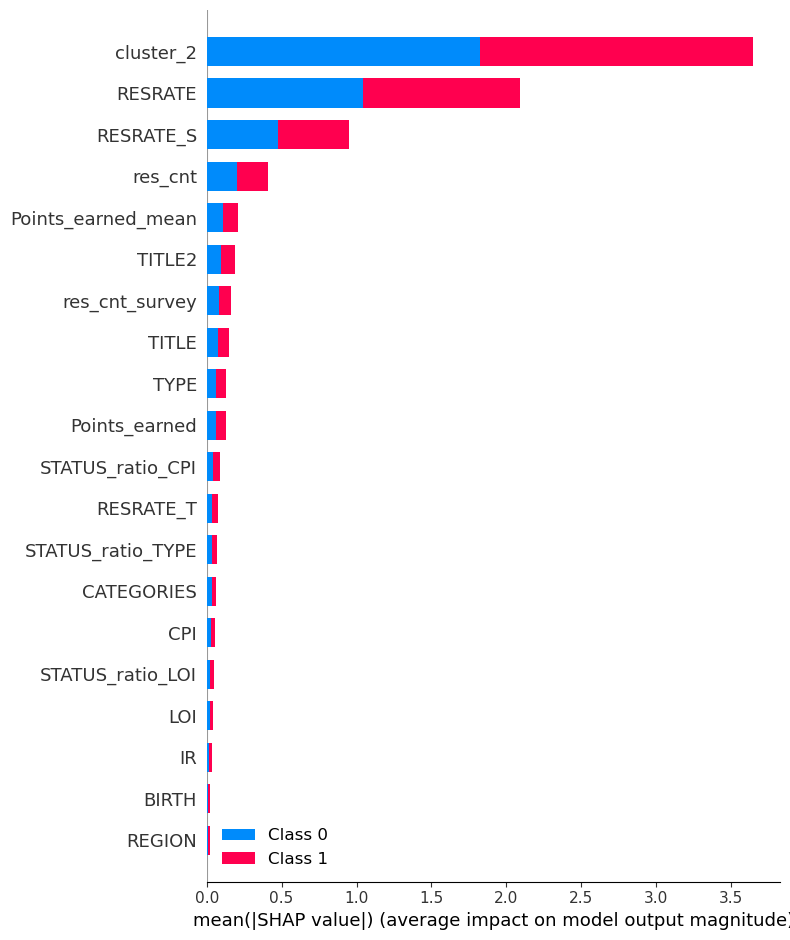

,column_name,shap_importance
87,cluster_2,1.822246
23,RESRATE,1.044437
24,RESRATE_S,0.475067
32,res_cnt,0.205265
35,Points_earned_mean,0.10564
...,...,...
60,REGION_MIN_IR,0.0
61,REGION_MAX_IR,0.0
62,TYPE_TOT_CPI,0.0
63,TYPE_AVG_CPI,0.0


In [56]:
# 'shap' 라이브러리를 사용하여 LightGM 모델의 예측에 대한 feature 중요도 계산

import shap # v2.0부터 추가

# 중요도를 확인할 데이터프레임
X_importance = X_test

# shap 라이브러리를 사용하여 모델 예측 설명
model = LGBMClassifier(random_state=0).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# summary_plot을 막대 그래프로 그리기
shap.summary_plot(shap_values, X_importance, plot_type='bar')

# SHAP 값의 절대값을 평균내어 feature 중요도 계산
shap_sum = np.abs(shap_values).mean(axis=1)[1,:]
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [57]:
# feature 중요도가 0 이상인 feature 선택
SHAP_THRESHOLD = 0
features_selected = importance_df.query('shap_importance > @SHAP_THRESHOLD').column_name.tolist()

# 선택된 feature를 X_train과 X_test를 필터링
X_train = X_train[features_selected]
X_test = X_test[features_selected]
print(X_train.shape)

(813650, 45)


In [58]:
# KMeansFeaturizer를 사용하여 클러스터링 feature 생성
kmf_hint = KMeansFeaturizer(k=10, target_scale=5, one_hot=False, random_state=0).fit(X_train)

# 'train' 데이터와 'test' 데이터에 클러스터링 feature 추가
train_cluster_features = kmf_hint.transform(X_train)
test_cluster_features = kmf_hint.transform(X_test)

# 클러스터링 feature를 'X_train'과 'X_test'에 추가
X_train = pd.concat([X_train, pd.Series(train_cluster_features, name='CLUSTER')], axis=1)
X_test = pd.concat([X_test, pd.Series(test_cluster_features, name='CLUSTER')], axis=1)

In [2]:
# 데이터 저장
with gzip.open('last dance_3.zip', 'wb') as f:
    pickle.dump([train,test,X_train, y_train, X_test, ID_test, cat_features, num_features], f)

<font color="#CC3D3D"><p>
# End